In [1]:
import numpy as np
import cv2
from skimage.io import imread
from utils import data_loader
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
mask_size = (192, 256)
mask = np.zeros(mask_size)
# mask_ = imread('examples/Image10.png', as_gray=True)
mask_ = np.zeros(mask_size)
mask_[125][125] = 1.0

In [3]:
mask, non_zero_points = data_loader.mapping_rescale_dot(mask, mask_)

In [4]:
mask.shape

(192, 256)

In [5]:
dm = data_loader.gaussian_filter_density(mask, np.fliplr(non_zero_points), k_nearest=3, fixed_sigma=None)

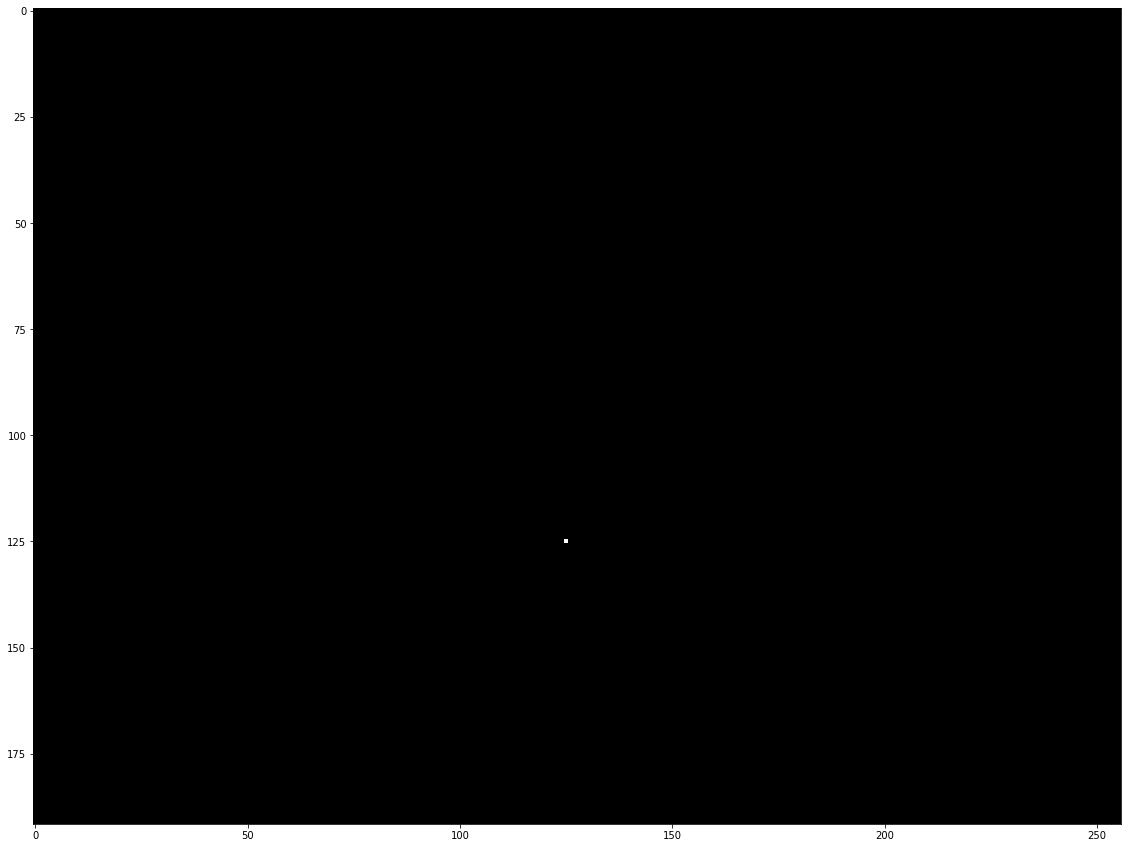

In [6]:
plt.figure(figsize=(30, 15))
plt.imshow(mask, cmap='gray')
plt.show()

In [7]:
np.sum(dm)

1.0

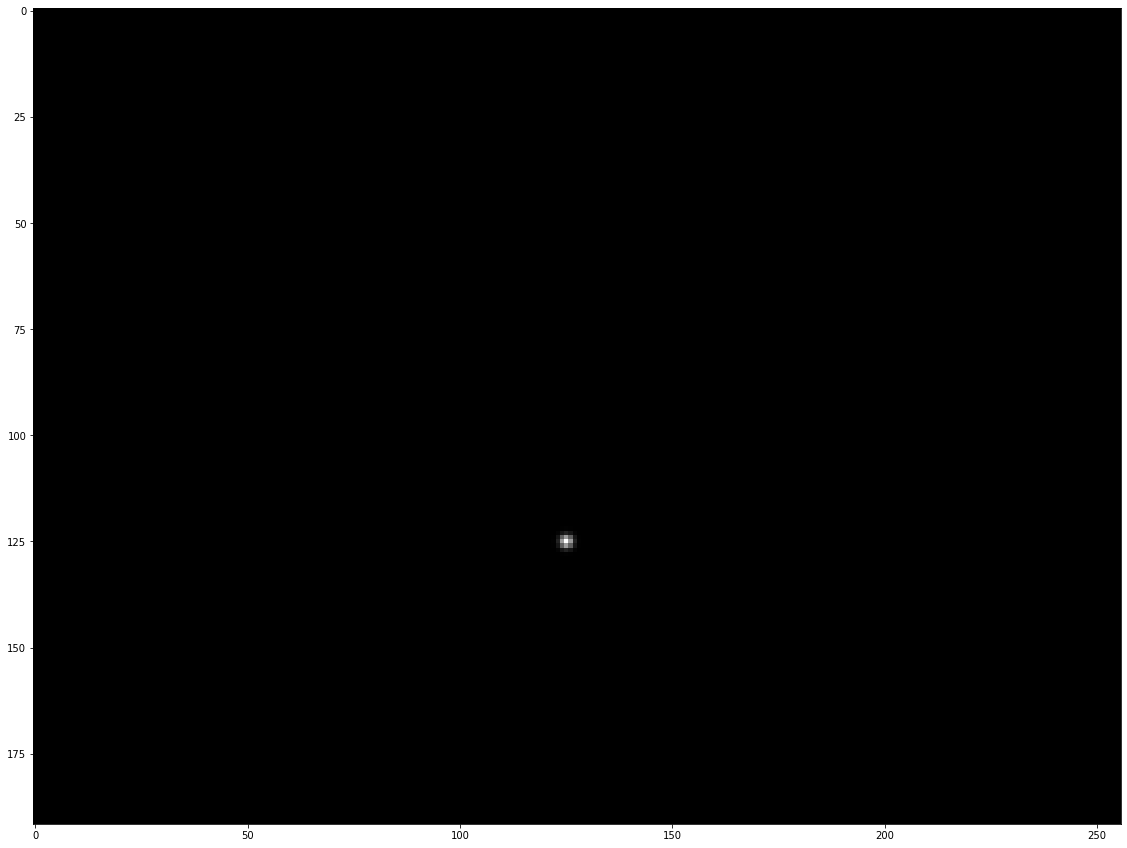

In [8]:
plt.figure(figsize=(30, 15))
plt.imshow(dm, cmap='gray')
plt.show()

In [9]:
dm.shape

(192, 256)

In [30]:
dm_resize = cv2.resize(dm,(int(dm.shape[1]/8),int(dm.shape[0]/8)),interpolation = cv2.INTER_AREA)

In [31]:
dm_resize1 = resize(dm, (int(dm.shape[0]/8),int(dm.shape[1]/8)), mode='constant', preserve_range=True)

In [32]:
dm_resize.shape

(24, 32)

In [33]:
dm_resize1.shape

(24, 32)

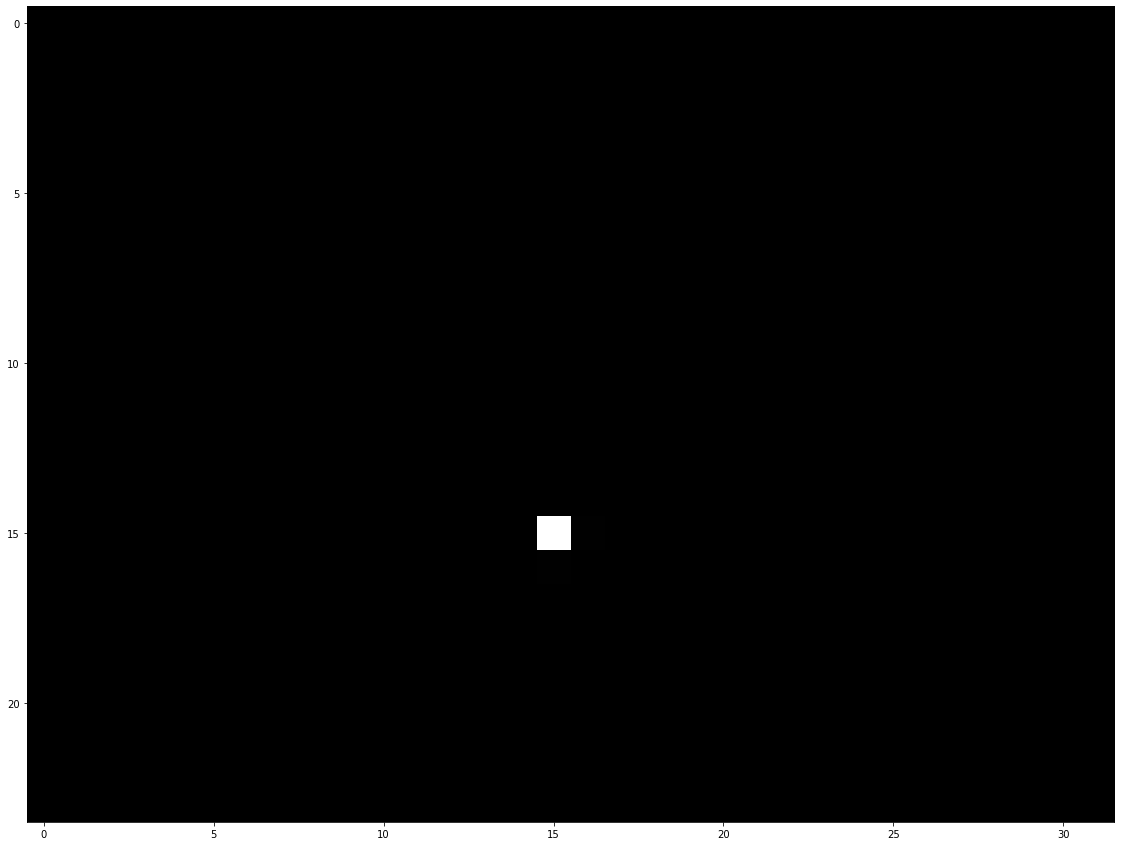

In [34]:
plt.figure(figsize=(30, 15))
plt.imshow(dm_resize, cmap='gray')
plt.show()

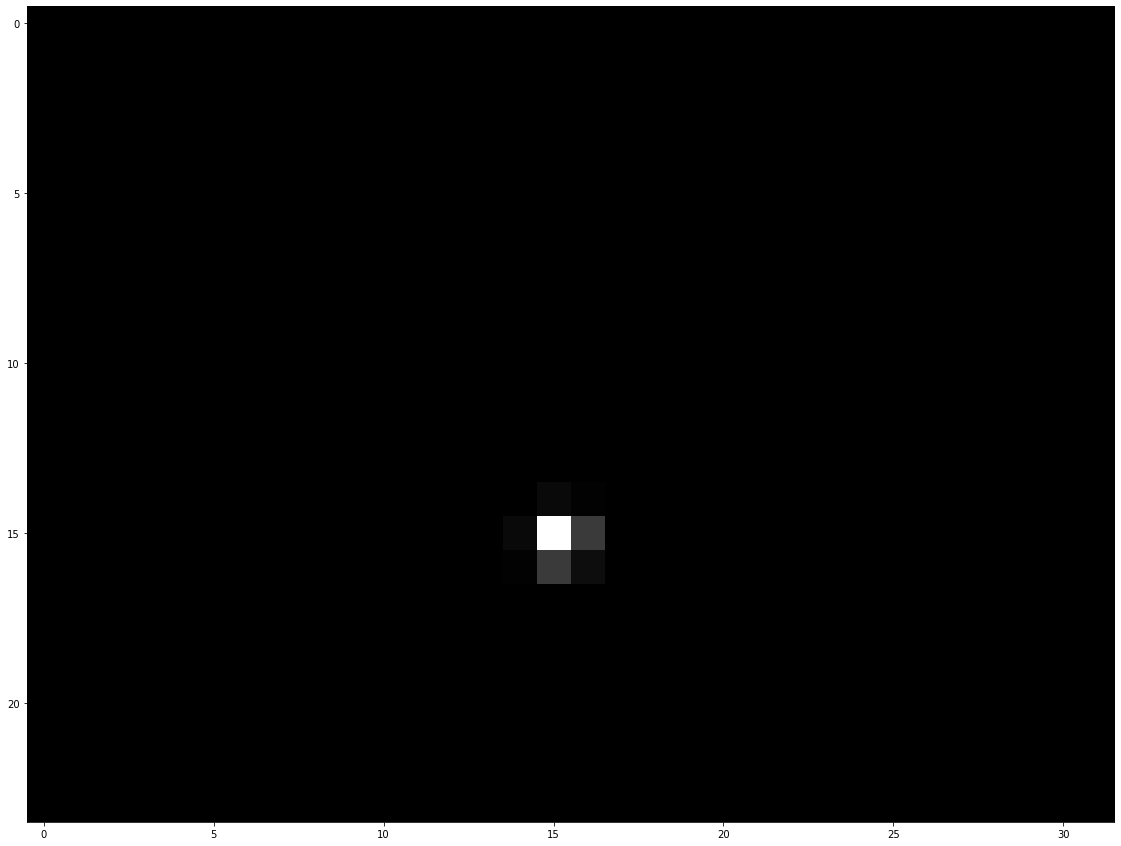

In [35]:
plt.figure(figsize=(30, 15))
plt.imshow(dm_resize1, cmap='gray')
plt.show()

In [41]:
print(np.sum(dm_resize))
print(np.sum(dm_resize1))

0.015625
0.015997995


In [42]:
ratio = np.sum(dm) / np.sum(dm_resize)

ratio1 = np.sum(dm) / np.sum(dm_resize1)

In [43]:
print(np.sum(dm_resize) * ratio)
print(np.sum(dm_resize1) * ratio1)

1.0
1.0


In [ ]:
tensor_test = np.zeros()